# Chapter 17: Deep Learning

This notebook contains the sample source code explained in the book *Hands-On Julia Programming, Sambit Kumar Dash, 2021, bpb Publications. All Rights Reserved.*

In [1]:
using Pkg
Pkg.activate("."); Pkg.instantiate()

  Activating environment at `~/work/books/HOJP/Chapter-17/Project.toml`
Precompiling project...
  ✓ GPUArrays
  ✓ LLVM
  ✓ GPUCompiler
  ✓ CUDA
  ✓ Flux
5 dependencies successfully precompiled in 76 seconds (169 already precompiled)


# What is Flux?

`Flux` is a framework to model and design machine learning problems. 

We try to model a simple linear regression equation using `Flux`. 

The data is generated using the equation, `y = 3x + 4`. We add gaussian random noise to it. 

In [2]:
x = 5*rand(100)
y = 3*x .+ 4 .+ randn(100);

If we use the statistical methods to solve for the linear regression, we shall obtain the values of `a` and `b` as shown below where `y = ax + b`.  

In [3]:
using Statistics
xy = x.*y
xm = mean(x)
ym = mean(y)
xym = mean(xy)
x2 = x.^2
x2m = mean(x2)

ac = (xym - xm*ym)/(x2m - xm*xm)
bc = ym - ac*xm
ac, bc

(3.1606790131497644, 3.5127087652577407)

The points and the equations are plotted below.

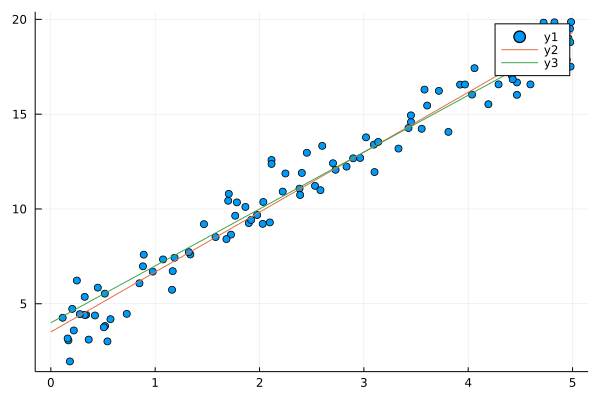

In [4]:
using Plots
plot(x, y, seriestype=:scatter)
plot!(0.0:5.0, [x->ac*x+bc, x->3x+4], seriestype=:line)

We model the same using `Flux` and estimate the cooefficients `a` and `b` using gradient descent.

In [5]:
# a, b and loss obtained in each iteration are stored in this matrix for plotting
r = Matrix{Float64}(undef, 100, 3)

using Flux
a, b = rand(1), rand(1) 
ps = params([a, b])


model(x, c0, c1) = c0.*x .+ c1
model(x) = model(x, a, b)

function loss(x, y, c0=a, c1=b)
    yp = model(x, c0, c1)
    mean((y .- yp).^2)
end    

data = zip(x, y)
opt = Descent(0.02)

i=1
for d in data
    gs = Flux.gradient(ps) do
        loss(d...)
    end
    Flux.Optimise.update!(opt, ps, gs)
    r[i, 1], r[i, 2], r[i, 3] = a[1], b[1], loss(x, y)    
    @info r[i, :]
    i += 1
end

┌ Info: [0.5544781644852365, 1.104688925060925, 96.42421363150602]
└ @ Main In[5]:27
┌ Info: [1.14619357178761, 1.4039614974061005, 61.44099687530121]
└ @ Main In[5]:27
┌ Info: [1.167665971268208, 1.4435401505412082, 59.91754099659827]
└ @ Main In[5]:27
┌ Info: [1.192692101300795, 1.5653837480441475, 57.126090273964394]
└ @ Main In[5]:27
┌ Info: [1.7883625751258756, 1.8333930587989262, 31.420651548735613]
└ @ Main In[5]:27
┌ Info: [2.653126870543277, 2.0856528090395954, 8.780564871696754]
└ @ Main In[5]:27
┌ Info: [2.8152324557284527, 2.1710876191271224, 6.057136974342373]
└ @ Main In[5]:27
┌ Info: [3.076285447539377, 2.3241539797959563, 2.8996024587401736]
└ @ Main In[5]:27
┌ Info: [3.256829329889915, 2.3631629460550463, 1.7797958717123927]
└ @ Main In[5]:27
┌ Info: [3.320884490479179, 2.403732241382037, 1.4963303934436019]
└ @ Main In[5]:27
┌ Info: [3.347635671497178, 2.4091254281655656, 1.422132859390599]
└ @ Main In[5]:27
┌ Info: [3.2245367008604475, 2.381570233041896, 1.8834477637

We plot the points, model predicted values as well as the regression line estimated from statistical methods. 

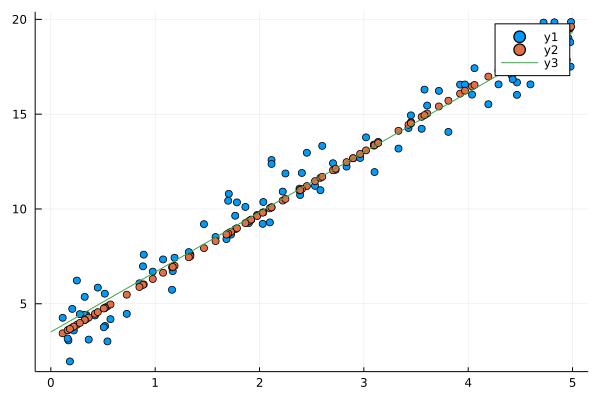

In [6]:
plot(x, [y, model(x)], seriestype=:scatter)
plot!(0.0:5.0, x->ac*x+bc, seriestype=:line)

In [7]:
# Will be used to plot the loss function against the parameters a and b. 
ploss(a, b) = loss(x, y, a, b)

ploss (generic function with 1 method)

In [8]:
idx = argmin(r[:,3]) # The index where Flux has found the best value for a and b
r[idx, 3], ploss(ac, bc) # the computed value by regression equation will always be better. 

(0.980982256014572, 0.9274942182313495)

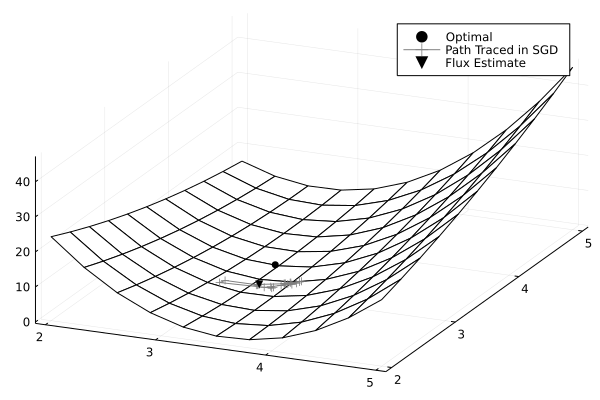

In [9]:
range_a=2.0:0.3:5.0
range_b=2.0:0.3:5.0

plot(range_a,range_b,ploss,st=:wireframe, camera=(30, 60))
plot!([ac], [bc], [ploss(ac, bc)], st=:scatter, label="Optimal", marker=:circle, color=:black)
plot!(r[80:100,1], r[80:100, 2], r[80:100, 3], st=:path3d, label="Path Traced in SGD", marker=:+, color=:grey)
plot!(r[idx:idx,1], r[idx:idx, 2], r[idx:idx, 3], st=:scatter, label="Flux Estimate",color=:black, marker=:dtriangle)

# Model Zoo

We shall see some of the model zoo samples here as representative examples for `Flux`.

# Neural Network Models

There are many classes of neural network models. The most common technique to classify them is based on topolgical arrangement and interaction of the nodes. Some of the commonly used types of models are:

1. Fully connected
2. Convolutional Neural Networks
3. Recurrent Neural Networks

## Fully Connected 

As the name suggests, each node of the previous layer is connected to the succeeding layers. These are also known as dense neural networks. 

In the example below, we will like to classify the handwritten black and white images from the MNIST dataset into their representive numbers. The data has 60,000 images for training and 10,000 for testing. Here are some of the salient features of the code:

1. Images are flattened to vectors of 784 values
2. They are put in batches of 1024 
3. The model consists of 3 layers:
    1. Input of 784 nodes
    2. Intermediate layer of 32 nodes
    3. Final output is presented to a 10 node output layer. 
4. The training is carried out for 10 epochs

We achieve an accuracy of 91.77% on the test data. 

In [10]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, logitcrossentropy, throttle, @epochs
using Base.Iterators: repeated
using Parameters: @with_kw
using CUDA
using MLDatasets
if has_cuda()       # Check if CUDA is available
    @info "CUDA is on"
    CUDA.allowscalar(false)
end

@with_kw mutable struct Args
    η::Float64 = 3e-4       # learning rate
    batchsize::Int = 1024   # batch size
    epochs::Int = 10        # number of epochs
    device::Function = gpu  # set as gpu, if gpu available
end

function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    # Loading Dataset
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtest, ytest = MLDatasets.MNIST.testdata(Float32)

    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    # One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    # Batching
    train_data = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_data = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_data, test_data
end

function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain(
        Dense(prod(imgsize), 32, relu),
        Dense(32, nclasses))
end

function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader
        l += logitcrossentropy(model(x), y)
    end
    l/length(dataloader)
end

function accuracy(data_loader, model)
    acc = 0
    for (x,y) in data_loader
        acc += sum(onecold(cpu(model(x))) .== onecold(cpu(y)))*1 / size(x,2)
    end
    acc/length(data_loader)
end

function train(; kws...)
    # Initializing Model parameters 
    args = Args(; kws...)

    # Load Data
    train_data,test_data = getdata(args)

    # Construct model
    m = build_model()
    train_data = args.device.(train_data)
    test_data = args.device.(test_data)
    m = args.device(m)
    loss(x,y) = logitcrossentropy(m(x), y)
    
    ## Training
    evalcb = () -> @show(loss_all(train_data, m))
    opt = ADAM(args.η)

    @epochs args.epochs Flux.train!(loss, params(m), train_data, opt, cb = evalcb)
    @show accuracy(train_data, m)
    @show accuracy(test_data, m)
end

cd(@__DIR__)
train()

┌ Info: Epoch 1
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 2.3269746f0
loss_all(train_data, m) = 2.3074389f0
loss_all(train_data, m) = 2.2883515f0
loss_all(train_data, m) = 2.269794f0
loss_all(train_data, m) = 2.2516823f0
loss_all(train_data, m) = 2.2339904f0
loss_all(train_data, m) = 2.2167459f0
loss_all(train_data, m) = 2.1998613f0
loss_all(train_data, m) = 2.1833684f0
loss_all(train_data, m) = 2.1671255f0
loss_all(train_data, m) = 2.1511424f0
loss_all(train_data, m) = 2.1353314f0
loss_all(train_data, m) = 2.1197011f0
loss_all(train_data, m) = 2.1042016f0
loss_all(train_data, m) = 2.0888135f0
loss_all(train_data, m) = 2.0734441f0
loss_all(train_data, m) = 2.0581293f0
loss_all(train_data, m) = 2.0427997f0
loss_all(train_data, m) = 2.0274796f0
loss_all(train_data, m) = 2.0120811f0
loss_all(train_data, m) = 1.9966638f0
loss_all(train_data, m) = 1.9811854f0
loss_all(train_data, m) = 1.9655627f0
loss_all(train_data, m) = 1.9498292f0
loss_all(train_data, m) = 1.9339731f0
loss_all(train_data, m) = 1.918037f0
loss_all(train

┌ Info: Epoch 2
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 1.4143443f0
loss_all(train_data, m) = 1.4020785f0
loss_all(train_data, m) = 1.3899401f0
loss_all(train_data, m) = 1.3779695f0
loss_all(train_data, m) = 1.366122f0
loss_all(train_data, m) = 1.3544376f0
loss_all(train_data, m) = 1.3428373f0
loss_all(train_data, m) = 1.331329f0
loss_all(train_data, m) = 1.3199164f0
loss_all(train_data, m) = 1.3086175f0
loss_all(train_data, m) = 1.2974684f0
loss_all(train_data, m) = 1.2864093f0
loss_all(train_data, m) = 1.2754912f0
loss_all(train_data, m) = 1.2646694f0
loss_all(train_data, m) = 1.2539153f0
loss_all(train_data, m) = 1.2432259f0
loss_all(train_data, m) = 1.2325938f0
loss_all(train_data, m) = 1.2219986f0
loss_all(train_data, m) = 1.2115445f0
loss_all(train_data, m) = 1.2012075f0
loss_all(train_data, m) = 1.1909688f0
loss_all(train_data, m) = 1.1808804f0
loss_all(train_data, m) = 1.1709127f0
loss_all(train_data, m) = 1.1610321f0
loss_all(train_data, m) = 1.1512252f0
loss_all(train_data, m) = 1.141471f0
loss_all(train_

┌ Info: Epoch 3
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


0.87142617f0
loss_all(train_data, m) = 0.8655519f0
loss_all(train_data, m) = 0.8597315f0
loss_all(train_data, m) = 0.85394025f0
loss_all(train_data, m) = 0.84827375f0
loss_all(train_data, m) = 0.8426626f0
loss_all(train_data, m) = 0.837059f0
loss_all(train_data, m) = 0.8315356f0
loss_all(train_data, m) = 0.8261498f0
loss_all(train_data, m) = 0.82091737f0
loss_all(train_data, m) = 0.8157883f0
loss_all(train_data, m) = 0.8107751f0
loss_all(train_data, m) = 0.80585456f0
loss_all(train_data, m) = 0.80100083f0
loss_all(train_data, m) = 0.7962092f0
loss_all(train_data, m) = 0.79140997f0
loss_all(train_data, m) = 0.7865977f0
loss_all(train_data, m) = 0.7818373f0
loss_all(train_data, m) = 0.7771329f0
loss_all(train_data, m) = 0.77248996f0
loss_all(train_data, m) = 0.7679495f0
loss_all(train_data, m) = 0.76350415f0
loss_all(train_data, m) = 0.7590639f0
loss_all(train_data, m) = 0.7547001f0
loss_all(train_data, m) = 0.7503412f0
loss_all(train_data, m) = 0.74603283f0
loss_all(train_data, m) = 0.7

┌ Info: Epoch 4
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


0.6329794f0
loss_all(train_data, m) = 0.6303693f0
loss_all(train_data, m) = 0.62773544f0
loss_all(train_data, m) = 0.62507266f0
loss_all(train_data, m) = 0.62247086f0
loss_all(train_data, m) = 0.6198763f0
loss_all(train_data, m) = 0.6172686f0
loss_all(train_data, m) = 0.6147092f0
loss_all(train_data, m) = 0.61222786f0
loss_all(train_data, m) = 0.6098317f0
loss_all(train_data, m) = 0.6074805f0
loss_all(train_data, m) = 0.60519576f0
loss_all(train_data, m) = 0.6029626f0
loss_all(train_data, m) = 0.6007659f0
loss_all(train_data, m) = 0.5986086f0
loss_all(train_data, m) = 0.596437f0
loss_all(train_data, m) = 0.59425634f0
loss_all(train_data, m) = 0.59207076f0
loss_all(train_data, m) = 0.5898888f0
loss_all(train_data, m) = 0.587716f0
loss_all(train_data, m) = 0.58559424f0
loss_all(train_data, m) = 0.583525f0
loss_all(train_data, m) = 0.581429f0
loss_all(train_data, m) = 0.57937956f0
loss_all(train_data, m) = 0.5772911f0
loss_all(train_data, m) = 0.57520676f0
loss_all(train_data, m) = 0.5731

┌ Info: Epoch 5
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 0.5197297f0
loss_all(train_data, m) = 0.51833194f0
loss_all(train_data, m) = 0.5169223f0
loss_all(train_data, m) = 0.51547194f0
loss_all(train_data, m) = 0.5139786f0
loss_all(train_data, m) = 0.5125226f0
loss_all(train_data, m) = 0.5110747f0
loss_all(train_data, m) = 0.509616f0
loss_all(train_data, m) = 0.5081942f0
loss_all(train_data, m) = 0.50682133f0
loss_all(train_data, m) = 0.50550073f0
loss_all(train_data, m) = 0.50419486f0
loss_all(train_data, m) = 0.5029298f0
loss_all(train_data, m) = 0.501696f0
loss_all(train_data, m) = 0.50048137f0
loss_all(train_data, m) = 0.49928835f0
loss_all(train_data, m) = 0.4980863f0
loss_all(train_data, m) = 0.49687904f0
loss_all(train_data, m) = 0.4956599f0
loss_all(train_data, m) = 0.49443355f0
loss_all(train_data, m) = 0.49320227f0
loss_all(train_data, m) = 0.49200365f0
loss_all(train_data, m) = 0.49084222f0
loss_all(train_data, m) = 0.48964432f0
loss_all(train_data, m) = 0.4884775f0
loss_all(train_data, m) = 0.4872616f0
l

┌ Info: Epoch 6
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


0.4520136f0
loss_all(train_data, m) = 0.45112565f0
loss_all(train_data, m) = 0.45019984f0
loss_all(train_data, m) = 0.44923198f0
loss_all(train_data, m) = 0.44829062f0
loss_all(train_data, m) = 0.44735858f0
loss_all(train_data, m) = 0.44642064f0
loss_all(train_data, m) = 0.44551826f0
loss_all(train_data, m) = 0.4446538f0
loss_all(train_data, m) = 0.44382483f0
loss_all(train_data, m) = 0.44299468f0
loss_all(train_data, m) = 0.4421904f0
loss_all(train_data, m) = 0.4414071f0
loss_all(train_data, m) = 0.44063577f0
loss_all(train_data, m) = 0.43988174f0
loss_all(train_data, m) = 0.43912593f0
loss_all(train_data, m) = 0.43837288f0
loss_all(train_data, m) = 0.43760788f0
loss_all(train_data, m) = 0.43683138f0
loss_all(train_data, m) = 0.43604428f0
loss_all(train_data, m) = 0.43527868f0
loss_all(train_data, m) = 0.4345409f0
loss_all(train_data, m) = 0.4337626f0
loss_all(train_data, m) = 0.43301088f0
loss_all(train_data, m) = 0.43221256f0
loss_all(train_data, m) = 0.43140885f0
loss_all(train_dat

┌ Info: Epoch 7
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 0.4094385f0
loss_all(train_data, m) = 0.4088531f0
loss_all(train_data, m) = 0.40823913f0
loss_all(train_data, m) = 0.40759063f0
loss_all(train_data, m) = 0.40689707f0
loss_all(train_data, m) = 0.4062267f0
loss_all(train_data, m) = 0.40556833f0
loss_all(train_data, m) = 0.40490684f0
loss_all(train_data, m) = 0.40428108f0
loss_all(train_data, m) = 0.4036877f0
loss_all(train_data, m) = 0.40312034f0
loss_all(train_data, m) = 0.40254426f0
loss_all(train_data, m) = 0.40198463f0
loss_all(train_data, m) = 0.40143988f0
loss_all(train_data, m) = 0.40090382f0
loss_all(train_data, m) = 0.40038568f0
loss_all(train_data, m) = 0.39987093f0
loss_all(train_data, m) = 0.3993609f0
loss_all(train_data, m) = 0.39884055f0
loss_all(train_data, m) = 0.3983076f0
loss_all(train_data, m) = 0.39776117f0
loss_all(train_data, m) = 0.39722952f0
loss_all(train_data, m) = 0.39671707f0
loss_all(train_data, m) = 0.3961612f0
loss_all(train_data, m) = 0.39562818f0
loss_all(train_data, m) = 0.3950

┌ Info: Epoch 8
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 0.37883914f0
loss_all(train_data, m) = 0.3784192f0
loss_all(train_data, m) = 0.37796608f0
loss_all(train_data, m) = 0.37748224f0
loss_all(train_data, m) = 0.37695122f0
loss_all(train_data, m) = 0.37643912f0
loss_all(train_data, m) = 0.3759412f0
loss_all(train_data, m) = 0.3754442f0
loss_all(train_data, m) = 0.3749827f0
loss_all(train_data, m) = 0.37455034f0
loss_all(train_data, m) = 0.3741371f0
loss_all(train_data, m) = 0.37371245f0
loss_all(train_data, m) = 0.37329683f0
loss_all(train_data, m) = 0.372891f0
loss_all(train_data, m) = 0.3724934f0
loss_all(train_data, m) = 0.3721128f0
loss_all(train_data, m) = 0.3717405f0
loss_all(train_data, m) = 0.37137514f0
loss_all(train_data, m) = 0.37100285f0
loss_all(train_data, m) = 0.3706178f0
loss_all(train_data, m) = 0.3702201f0
loss_all(train_data, m) = 0.36982965f0
loss_all(train_data, m) = 0.36945343f0
loss_all(train_data, m) = 0.36902922f0
loss_all(train_data, m) = 0.36862263f0
loss_all(train_data, m) = 0.36818233f

┌ Info: Epoch 9
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 0.35600373f0
loss_all(train_data, m) = 0.35568416f0
loss_all(train_data, m) = 0.35532644f0
loss_all(train_data, m) = 0.35494334f0
loss_all(train_data, m) = 0.35451296f0
loss_all(train_data, m) = 0.3541004f0
loss_all(train_data, m) = 0.35370323f0
loss_all(train_data, m) = 0.35330683f0
loss_all(train_data, m) = 0.35294443f0
loss_all(train_data, m) = 0.35260886f0
loss_all(train_data, m) = 0.35228923f0
loss_all(train_data, m) = 0.35195568f0
loss_all(train_data, m) = 0.3516279f0
loss_all(train_data, m) = 0.35130778f0
loss_all(train_data, m) = 0.3509938f0
loss_all(train_data, m) = 0.3506989f0
loss_all(train_data, m) = 0.35041508f0
loss_all(train_data, m) = 0.3501416f0
loss_all(train_data, m) = 0.34986657f0
loss_all(train_data, m) = 0.3495785f0
loss_all(train_data, m) = 0.34928006f0
loss_all(train_data, m) = 0.34898618f0
loss_all(train_data, m) = 0.34870446f0
loss_all(train_data, m) = 0.34837383f0
loss_all(train_data, m) = 0.34805322f0
loss_all(train_data, m) = 0.347

┌ Info: Epoch 10
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


loss_all(train_data, m) = 0.33808622f0
loss_all(train_data, m) = 0.33783343f0
loss_all(train_data, m) = 0.3375418f0
loss_all(train_data, m) = 0.3372284f0
loss_all(train_data, m) = 0.33686978f0
loss_all(train_data, m) = 0.33652687f0
loss_all(train_data, m) = 0.33619878f0
loss_all(train_data, m) = 0.33587143f0
loss_all(train_data, m) = 0.33557582f0
loss_all(train_data, m) = 0.33530456f0
loss_all(train_data, m) = 0.3350483f0
loss_all(train_data, m) = 0.33477798f0
loss_all(train_data, m) = 0.3345098f0
loss_all(train_data, m) = 0.33424696f0
loss_all(train_data, m) = 0.33398867f0
loss_all(train_data, m) = 0.3337493f0
loss_all(train_data, m) = 0.33352214f0
loss_all(train_data, m) = 0.33330643f0
loss_all(train_data, m) = 0.3330929f0
loss_all(train_data, m) = 0.3328681f0
loss_all(train_data, m) = 0.33263478f0
loss_all(train_data, m) = 0.3324041f0
loss_all(train_data, m) = 0.33218193f0
loss_all(train_data, m) = 0.33191064f0
loss_all(train_data, m) = 0.3316445f0
loss_all(train_data, m) = 0.331349

0.9152224170918368

## Convolutional Neural Network

We use the same handwritten digit detection MNIST dataset but apply a convolutional network on it. For the images, we add an additional dimension. The images are returned in sizes of 28 x 28 x 1. We use images in the batches of 128. 

The models is designed with layers of convolution, batch normalization and max pooling. Dropouts are used twice at a rate of 10%. With 6000+ parameters, we can achieve an accuracy of 99% in about 10 epochs. 

Convolutions operations get significant boost with GPU and TPUs. The example may take several minutes on a pure CPU set up. 

In [11]:
# Classifies MNIST digits with a convolutional network.
# Writes out saved model to the file "mnist_conv.bson".
# Demonstrates basic model construction, training, saving,
# conditional early-exit, and learning rate scheduling.
#
# This model, while simple, should hit around 99% test
# accuracy after training for approximately 20 epochs.

using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, logitcrossentropy
using Base.Iterators: partition
using Printf, BSON
using Parameters: @with_kw
using CUDA
using MLDatasets
if has_cuda()
    @info "CUDA is on"
    CUDA.allowscalar(false)
end

@with_kw mutable struct ArgsC
    η::Float64 = 3e-3
    epochs::Int = 20
    batchsize = 128
    savepath::String = "./" 
    device::Function = gpu 
    bestacc = 0.99
end

function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    # Loading Dataset
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtest, ytest = MLDatasets.MNIST.testdata(Float32)

    # Reshape Data to 28x28x1xN to ensure images have 3 dimensions
    w, h, _ = size(xtrain)
    xtrain = reshape(xtrain, (w, h, 1, :))
    xtest = reshape(xtest, (w, h, 1, :))

    # One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    # Batching and shuffling the training data
    train_data = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_data = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_data, test_data
end


function build_model(args; imgsize = (28,28,1), nclasses = 10)
    return Chain(
        # Input image 28x28x1 image
        Conv((3, 3), imgsize[3]=>4, relu), #Output: 26x26x4 Params: 3x3x1x4=36
        BatchNorm(4),
        Conv((3, 3), 4=>4, relu), #Output: 24x24x4 Params: 3x3x4x4=144
        BatchNorm(4),
        MaxPool((2,2)), #Output: 12x12x4
        Dropout(0.1),
        Conv((3, 3), 4=>8, relu), #Output: 10x10x8 Params: 3x3x4x8=288
        BatchNorm(8),
        Conv((3, 3), 8=>8, relu), #Output: 8x8x8 Params: 3x3x8x8=576
        BatchNorm(8),
        MaxPool((2,2)), #Output: 4x4x8 
        Dropout(0.1),
        Conv((3, 3), 8=>32, pad=(1, 1), relu), #Output: 4x4x32 Params: 3x3x8x32=2304
        BatchNorm(32),
        Conv((3, 3), 32=>nclasses, relu), #Output: 2x2x10 Params: 3x3x32x10=2880
        BatchNorm(10),
        AdaptiveMeanPool((1, 1)), #Output: 1x1x10
        flatten #Output: 10
    )
end

# We augment `x` a little bit here, adding in gaussian random noise. 
augment(x, device) = x .+ device(0.05f0*randn(eltype(x), size(x)))

accuracy(x, y, model) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))

function accuracy(dataset, model)
    s, l = 0, 0
    for (x, y) in dataset
        s += sum(onecold(cpu(model(x))) .== onecold(cpu(y)))
        l += size(y, 2)
    end
    return s/l
end


function train(; kws...)
    args = ArgsC(; kws...)

    @info("Loading data set")
    train_set, test_set = getdata(args)


    @info("Building model...")
    model = build_model(args) 

    # Load model and datasets onto GPU, if enabled
    train_set = args.device.(train_set)
    test_set = args.device.(test_set)
    model = args.device(model)
    
    # Make sure our model is nicely precompiled before starting our training loop
    model(train_set[1][1])

    # `loss()` calculates the crossentropy loss between our prediction `y_hat`
    # (calculated from `model(x)`) and the ground truth `y`.  We augment the data
    # a bit, adding gaussian random noise to our image to make it more robust.
    function loss(x, y)    
        x̂ = augment(x, args.device)
        ŷ = model(x̂)
        return logitcrossentropy(ŷ, y)
    end

    # Train our model with the given training set using the ADAM optimizer and
    # printing out performance against the test set as we go.
    opt = ADAM(args.η)

    @info("Beginning training loop...")
    best_acc = 0.0
    last_improvement = 0
    for epoch_idx in 1:args.epochs
        # Train for a single epoch
        Flux.train!(loss, params(model), train_set, opt)

        # Calculate accuracy:
        acc = accuracy(test_set, model)
        @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

        # If this is the best accuracy we've seen so far, save the model out
        if acc >= best_acc
            @info(" -> New best accuracy! Saving model out to mnist_conv.bson")
            BSON.@save joinpath(args.savepath, "mnist_conv.bson") model=cpu(model) epoch_idx acc
            best_acc = acc
            last_improvement = epoch_idx
        end
        
        # If our accuracy is good enough, quit.
        if acc >= args.bestacc
            @info(" -> Early-exiting: We reached our target accuracy of $(args.bestacc*100)%")
            break
        end

        # If we haven't seen improvement in 5 epochs, drop our learning rate:
        if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
            opt.eta /= 10.0
            @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")
   
            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx
        end

        if epoch_idx - last_improvement >= 10
            @warn(" -> We're calling this converged.")
            break
        end
    end
end

# Testing the model, from saved model
function test(; kws...)
    args = ArgsC(; kws...)
    
    # Loading the test data
    _,test_set = getdata(args)
    
    # Loading the saved parameters
    BSON.@load joinpath(args.savepath, "mnist_conv.bson") model
    
    test_set = args.device.(test_set)
    model = args.device(model)
    @show accuracy(test_set, model)
end

cd(@__DIR__) 
train()
test()

┌ Info: Loading data set
└ @ Main In[11]:96
┌ Info: Building model...
└ @ Main In[11]:100
┌ Info: Beginning training loop...
└ @ Main In[11]:124
┌ Info: [1]: Test accuracy: 0.9826
└ @ Main In[11]:133
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[11]:137
┌ Info: [2]: Test accuracy: 0.9874
└ @ Main In[11]:133
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[11]:137
┌ Info: [3]: Test accuracy: 0.9890
└ @ Main In[11]:133
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[11]:137
┌ Info: [4]: Test accuracy: 0.9892
└ @ Main In[11]:133
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[11]:137
┌ Info: [5]: Test accuracy: 0.9902
└ @ Main In[11]:133
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[11]:137
┌ Info:  -> Early-exiting: We reached our target accuracy of 99.0%
└ @ Main In[11]:145


accuracy(test_set, model) = 0.9902


0.9902

## Recurrent Neural Networks

Some activities are essentially sequential. In texts, a word follows the other and their sequence is useful as they form a context. Similarly, voice phonemes follow one after the other for establishment of context. Recurrent networks are ideal for such situations. The data is fed into the network as tokens and the internal state of the network is updated at each time step. The state is transformed with an activation and the output is presented as a sequence of events. 

We will download text from wikipedia in various languages. We pass the sentences as a sequence of characters into a network and infer the language that they represent. 

In [12]:
using Cascadia, Gumbo, HTTP

pages = Dict(
  :en => ["Wikipedia", "Osama_bin_Laden_(elephant)", "List_of_lists_of_lists", "Josephine_Butler", "Canadian_football", "Judaism"],
  :it => ["Wikipedia", "Ludovico_Einaudi", "Filosofia_della_scienza", "Pizza", "Effie_Gray", "Galeazzo_Maria_Sforza", "Ebraismo"],
  :fr => ["Wikipedia", "Philosophie_des_sciences", "Seconde_Guerre_mondiale", "Eric_Hakonsson"],
  :es => ["Wikipedia", "Chorizo", "Historia_de_Barcelona", "Espania", "Las_Vegas_Strip", "Judaismo"],
  :da => ["Wikipedia", "H.C._Andersen", "L.A._Ring", "Jiangxi", "NATO", "Thomas_Edison", "Bangladesh"])

rawpage(url) = parsehtml(String(HTTP.get(url).body)).root

content(url) = join((collect(nodeText(m) for m in eachmatch(sel".mw-parser-output > p", rawpage(url)))), "\n")

cd(@__DIR__)
mkpath("corpus")

for (lang, ps) in pages
    open("corpus/$lang.txt", "w") do io
        for p in ps
            write(io, content("https://$lang.wikipedia.org/wiki/$p"))
        end
    end
end

A simple LSTM can be used to model language identification. 

In [13]:
using Flux
using Flux: onehot, onehotbatch, logitcrossentropy, reset!, throttle, onecold, @epochs
using Statistics: mean
using Random
using Unicode
using Parameters: @with_kw

@with_kw mutable struct ArgsR
    lr::Float64 = 1e-2     # learning rate
    N::Int = 20            # Number of perceptrons in hidden layer
    test_len::Int = 100    # length of test data
    epochs::Int = 5        # No of epochs
    langs_len::Int = 0     # Number of different languages in Corpora
    alphabet_len::Int = 0  # Total number of characters possible, in corpora
    throttle::Int = 1     # throttle timeout
end

function get_processed_data(args)
    corpora = Dict()

    for file in readdir("corpus")
        lang = Symbol(match(r"(.*)\.txt", file).captures[1])
        corpus = split(String(read("corpus/$file")), ".")
        corpus = strip.(Unicode.normalize.(corpus, casefold=true, stripmark=true))
        corpus = filter(!isempty, corpus)
        corpora[lang] = corpus
    end

    langs = collect(keys(corpora))
    args.langs_len = length(langs)
    alphabet = ['a':'z'; '0':'9'; ' '; '\n'; '_']
    args.alphabet_len = length(alphabet)

    # See which chars will be represented as "unknown"
    unique(filter(x -> x ∉ alphabet, join(vcat(values(corpora)...))))

    dataset = [(onehotbatch(s, alphabet, '_'), onehot(l, langs)) for l in langs for s in corpora[l]] |> shuffle

    train, test = dataset[1:end-args.test_len], dataset[end-args.test_len+1:end]
    return train, test
end

function build_model(args)
    return LSTM(args.alphabet_len, args.langs_len)
end
 
function model(x, scanner)
    return scanner.(x.data)[end]
end

function train(; kws...)
    # Initialize Hyperparameters
    args = ArgsR(; kws...)
    # Load Data
    train_data, test_data = get_processed_data(args)

    @info("Constructing Model...")
    scanner = build_model(args)

    loss(x, y) = logitcrossentropy(model(x, scanner), y)
    testloss() = mean(loss(t...) for t in test_data)
    acc(x, y)  = sum(onecold(model(x, scanner)) .== onecold(y))*1.0
    testacc() = mean(acc(t...) for t in test_data)
    
    opt = ADAM(args.lr)
    ps = params(scanner)
    evalcb = () -> @show testloss() testacc()
    @info("Training...")
    @epochs args.epochs Flux.train!(loss, ps, train_data, opt, cb = throttle(evalcb, args.throttle))
end

cd(@__DIR__)
train()

┌ Info: Constructing Model...
└ @ Main In[13]:57
┌ Info: Training...
└ @ Main In[13]:68
┌ Info: Epoch 1
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


testloss() = 1.6204171f0
testacc() = 0.14
testloss() = 1.599029f0
testacc() = 0.27
testloss() = 1.5801698f0
testacc() = 0.27
testloss() = 1.5702171f0
testacc() = 0.27
testloss() = 1.5568364f0
testacc() = 0.31
testloss() = 1.5565846f0
testacc() = 0.3
testloss() = 1.5031006f0
testacc() = 0.34
testloss() = 1.4720633f0
testacc() = 0.35
testloss() = 1.5325301f0
testacc() = 0.28
testloss() = 1.4590082f0
testacc() = 0.39
testloss() = 1.6081358f0
testacc() = 0.2
testloss() = 1.437052f0
testacc() = 0.39
testloss() = 1.4486759f0
testacc() = 0.38
testloss() = 1.4024926f0
testacc() = 0.41
testloss() = 1.4216874f0
testacc() = 0.38
testloss() = 1.4272839f0
testacc() = 0.37
testloss() = 1.3615423f0
testacc() = 0.42
testloss() = 1.338821f0
testacc() = 0.44
testloss() = 1.3401738f0
testacc() = 0.44
testloss() = 1.3300954f0
testacc() = 0.46
testloss() = 1.3381903f0
testacc() = 0.43
testloss() = 1.3660893f0
testacc() = 0.42
testloss() = 1.3440237f0
testacc() = 0.44
testloss() = 1.3094434f0
testacc() = 0.

┌ Info: Epoch 2
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


testloss() = 1.0482701f0
testacc() = 0.66
testloss() = 1.0289294f0
testacc() = 0.64
testloss() = 1.0068613f0
testacc() = 0.67
testloss() = 1.0386277f0
testacc() = 0.65
testloss() = 0.9966387f0
testacc() = 0.67
testloss() = 1.0411777f0
testacc() = 0.65
testloss() = 0.974244f0
testacc() = 0.66
testloss() = 1.0104944f0
testacc() = 0.67
testloss() = 1.0476588f0
testacc() = 0.65
testloss() = 1.2958667f0
testacc() = 0.52
testloss() = 1.2649341f0
testacc() = 0.51
testloss() = 1.1625156f0
testacc() = 0.57
testloss() = 1.0667747f0
testacc() = 0.62
testloss() = 1.2015747f0
testacc() = 0.52
testloss() = 1.1939281f0
testacc() = 0.52
testloss() = 1.0994756f0
testacc() = 0.63
testloss() = 1.1594397f0
testacc() = 0.55
testloss() = 1.1403365f0
testacc() = 0.6
testloss() = 1.0155336f0
testacc() = 0.67
testloss() = 1.0292529f0
testacc() = 0.67
testloss() = 1.0338768f0
testacc() = 0.64
testloss() = 1.0373815f0
testacc() = 0.65
testloss() = 1.0399991f0
testacc() = 0.65
testloss() = 0.99331355f0
testacc() 

┌ Info: Epoch 3
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


testloss() = 1.7157668f0
testacc() = 0.26
testloss() = 1.7045032f0
testacc() = 0.25
testloss() = 1.5255972f0
testacc() = 0.34
testloss() = 1.5903444f0
testacc() = 0.3
testloss() = 1.3315384f0
testacc() = 0.45
testloss() = 1.3798031f0
testacc() = 0.44
testloss() = 1.2985594f0
testacc() = 0.47
testloss() = 1.2895607f0
testacc() = 0.46
testloss() = 1.2071325f0
testacc() = 0.54
testloss() = 1.224989f0
testacc() = 0.51
testloss() = 1.1756375f0
testacc() = 0.54
testloss() = 1.127009f0
testacc() = 0.56
testloss() = 1.0809292f0
testacc() = 0.6
testloss() = 1.117095f0
testacc() = 0.59
testloss() = 1.0814649f0
testacc() = 0.62
testloss() = 1.0339023f0
testacc() = 0.64
testloss() = 1.0396098f0
testacc() = 0.65
testloss() = 1.032391f0
testacc() = 0.69
testloss() = 1.0059816f0
testacc() = 0.7
testloss() = 0.9727536f0
testacc() = 0.72
testloss() = 0.96858793f0
testacc() = 0.69
testloss() = 0.9722389f0
testacc() = 0.72
testloss() = 0.96421987f0
testacc() = 0.72
testloss() = 0.953495f0
testacc() = 0.7

┌ Info: Epoch 4
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


testloss() = 0.90650487f0
testacc() = 0.72
testloss() = 0.92378616f0
testacc() = 0.71
testloss() = 0.9088261f0
testacc() = 0.73
testloss() = 0.93349093f0
testacc() = 0.71
testloss() = 0.9313524f0
testacc() = 0.72
testloss() = 0.9763574f0
testacc() = 0.66
testloss() = 0.9329401f0
testacc() = 0.69
testloss() = 0.915075f0
testacc() = 0.72
testloss() = 0.9429037f0
testacc() = 0.71
testloss() = 0.9469244f0
testacc() = 0.72
testloss() = 0.94390327f0
testacc() = 0.7
testloss() = 0.95652044f0
testacc() = 0.7
testloss() = 0.9172474f0
testacc() = 0.73
testloss() = 0.9771173f0
testacc() = 0.67
testloss() = 0.9545147f0
testacc() = 0.68
testloss() = 1.0190799f0
testacc() = 0.67
testloss() = 0.9789267f0
testacc() = 0.68
testloss() = 0.9559327f0
testacc() = 0.69
testloss() = 0.9364169f0
testacc() = 0.7
testloss() = 0.96139175f0
testacc() = 0.7
testloss() = 1.0107647f0
testacc() = 0.66
testloss() = 0.97033f0
testacc() = 0.71
testloss() = 0.95217764f0
testacc() = 0.71
testloss() = 0.96327835f0
testacc(

┌ Info: Epoch 5
└ @ Main /home/sambit/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


testloss() = 0.93509775f0
testacc() = 0.71
testloss() = 1.0687331f0
testacc() = 0.63
testloss() = 1.0974408f0
testacc() = 0.64
testloss() = 1.0120382f0
testacc() = 0.65
testloss() = 0.942318f0
testacc() = 0.68
testloss() = 0.92040956f0
testacc() = 0.72
testloss() = 0.9186459f0
testacc() = 0.72
testloss() = 1.0004804f0
testacc() = 0.68
testloss() = 0.94265044f0
testacc() = 0.68
testloss() = 0.940037f0
testacc() = 0.7
testloss() = 0.94403106f0
testacc() = 0.67
testloss() = 0.94179237f0
testacc() = 0.69
testloss() = 0.93626267f0
testacc() = 0.7
testloss() = 0.941834f0
testacc() = 0.69
testloss() = 0.93474096f0
testacc() = 0.71
testloss() = 0.91676664f0
testacc() = 0.72
testloss() = 0.93130815f0
testacc() = 0.7
testloss() = 0.9085236f0
testacc() = 0.68
testloss() = 0.94366175f0
testacc() = 0.69
testloss() = 0.9147814f0
testacc() = 0.68
testloss() = 0.9226418f0
testacc() = 0.68
testloss() = 0.916414f0
testacc() = 0.7
testloss() = 0.92448294f0
testacc() = 0.66
testloss() = 0.8880934f0
testac

# Conclusion

# Exercises